In [1]:
import yaml
from httplib2 import Http
from apiclient import discovery
from altair_saver import save
from gspread_dataframe import set_with_dataframe, get_as_dataframe
from oauth2client.service_account import ServiceAccountCredentials
import gspread
import pandas as pd
from urllib.parse import urlparse
import pycountry as pyc
import pycountry_convert as pycc
import os
import sys
import re
import numpy as np
import altair as alt

In [2]:
import requests
from bs4 import BeautifulSoup
import nltk
import urllib.parse
from datetime import date, datetime

In [3]:
sys.path.append('/Users/eddie.lyons/Documents/Bitbucket/third-party-data-analyser/')

In [4]:
from analyser.utilities.google_tools import *
from analyser.utilities.utils import *
from analyser.analysis_base_class import AnalysisBaseClass
from analyser.datasets.bitcoin_whos_who import BitcoinWhosWho

In [7]:
credentials_file_path = '/Users/eddie.lyons/Documents/Bitbucket/third-party-data-analyser/creds.json'

scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name(credentials_file_path, scope)
client = gspread.authorize(creds)

drive = discovery.build('drive', 'v3', http=creds.authorize(Http()))

In [277]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [274]:
bww = BitcoinWhosWho()

Failed to import source as DataFrame. Exception: [Errno 2] No such file or directory: '/Users/eddie.lyons/Documents/Bitbucket/third-party-data-analyser/third-party-data-302913-9ea8e5677427.json'


In [8]:
bww.df = bww.df.head(500)

In [10]:
bww.get_address_info()

In [11]:
bww.pct_labelled_addresses()

31.0

In [12]:
bww.match_actors()

In [15]:
bww.pct_actor_matches()

3.225806451612903

In [ ]:
bww.get_median_date('last_seen_time')

In [267]:
class WaltzEndpoint:
    BTC = 'btc-full'
    LTC = 'ltc'
    BCH = 'bch'
    ZEC = 'zec'
    SUFFIX = '.mc.dev.aws.elliptic.local/addresses'


ENDPOINT_OF_ASSET = {
    'BTC': 'http://' + WaltzEndpoint.BTC + WaltzEndpoint.SUFFIX,
    'LTC': 'http://' + WaltzEndpoint.LTC + WaltzEndpoint.SUFFIX,
    'BCH': 'http://' + WaltzEndpoint.BCH + WaltzEndpoint.SUFFIX,
    'ZEC': 'http://' + WaltzEndpoint.ZEC + WaltzEndpoint.SUFFIX
}

# most regex patterns taken from: https://github.com/k4m4/cryptaddress-validator

ASSET_REGEX = {
    'BTC': r'\bbc1[02-9ac-hj-np-z]{11,71}\b|\b[13][a-zA-HJ-NP-Z0-9]{23,39}\b',
    'LTC': r'\bltc1[02-9ac-hj-np-z]{10,71}$|\b[LM][a-km-zA-HJ-NP-Z1-9]{26,33}\b',
    'BCH': r'\bbitcoincash:q[a-z0-9]{41}\b|\bq[a-z0-9]{41}\b',
    'ZEC': r'\bt[123][a-zA-HJ-NP-Z0-9]{33}$|\bzs[02-9ac-hj-np-z]{76}\b|\bzc[a-zA-HJ-NP-Z0-9]{93}\b',
    'ETH': r'\b0x[a-fA-F0-9]{40}\b',
    'DOGE': r'\bD{1}[5-9A-HJ-NP-U]{1}[1-9A-HJ-NP-Za-km-z]{32}\b',
    'DASH': r'\bX[1-9A-HJ-NP-Za-km-z]{33}\b',
    'XMR': r'\b[48][0-9AB][1-9A-HJ-NP-Za-km-z]{93}\b',
    'NEO': r'\bA[0-9a-zA-Z]{33}\b',
    'XRP': r'\br[0-9a-zA-Z]{33}\b',
    'ZIL': r'\bzil1[a-hj-np-z0-9]{38}\b',
    'BNB': r'\bbnb1[a-hj-np-z0-9]{38}\b',
    'XLM': r'\b[G][A-Z0-9]{55}\b',
    'ZEN': r'\bzn[a-km-zA-HJ-NP-Z1-9]{24,33}\b'
}

In [236]:
headers = {
    'Content-Type': 'application/json',
}

data = '{"addresses":["1HQq7aw1Y53sH4gyBaSdCYiHpX7P4fzA1E","17RjNryhJZt621oSYLaDyY3ZaJW59BcwuR"],"get_clusters":true}'

response = requests.post('http://btc-full.mc.dev.aws.elliptic.local/addresses', headers=headers, data=data)

In [269]:
def get_info_from_list_of_addresses(addresses: List[str], asset_ticker: str) -> dict:
    # all addresses passed must be of the same currency otherwise using waltz's batching endpoint won't work

    all_responses = {}

    if len(addresses) <= 0:
        print('No {} addresses passed'.format(asset_ticker))
        return all_responses

    headers = {
        'Content-Type': 'application/json',
    }
    data = '{"addresses":' + json.dumps(addresses) + ',"get_clusters":true}'

    try:
        response = requests.post(ENDPOINT_OF_ASSET[asset_ticker], headers=headers, data=data)

        if response.ok:
            clusters = response.json()['clusters']
            addresses = response.json()['addresses']

            for cluster, address in zip(clusters, addresses):
                dict1 = {}
                addr = address['base58']
                labels = cluster['labels']

                if len(labels) > 0:
                    dict1['Elliptic Label'] = labels[0]['name']
                    dict1['Category'] = labels[0]['category']
                    dict1['Elliptic URL'] = labels[0]['info']['url']

                dict1['balance'] = cluster['satoshis_balance'] / 100000000
                dict1['btc_in'] = cluster['satoshis_in'] / 100000000
                dict1['btc_out'] = cluster['satoshis_out'] / 100000000
                dict1['txs_in'] = cluster['total_incoming_edges']
                dict1['txs_out'] = cluster['total_outgoing_edges']
                dict1['address_count'] = cluster['address_count']
                dict1['first_seen_time'] = int(str(address['first_seen_time'])[:10])
                dict1['last_seen_time'] = int(str(address['last_seen_time'])[:10])

                all_responses.update({addr: dict1})

        else:
            print(response.text)

        return all_responses

    except Exception as e:
        logger.error(
            'Failed to get address info for {} addresses./nException: {}'.format(
                asset_ticker, e)
        )

In [278]:
def get_address_info(self):
    btc_df = self.split_dataframe_by_asset('BTC')
    ltc_df = self.split_dataframe_by_asset('LTC')
    bch_df = self.split_dataframe_by_asset('BCH')
    zec_df = self.split_dataframe_by_asset('ZEC')
    non_utxo_df = self.split_dataframe_by_asset(non_utxo=True)
    
    splits = [btc_df, ltc_df, bch_df, zec_df]
    assets = ['BTC', 'LTC', 'BCH', 'ZEC']
    
    address_statistics = {}
    for df, asset in zip(splits, assets):
        for index, dataframe in df.groupby(np.arange(len(df))//200):
            chunk_stats = get_info_from_list_of_addresses(dataframe['Address'], asset)
            address_statistics = {**address_statistics, **chunk_stats}  # syntax in python 3.9+ is statistics = {statistics | df}

    statistics = pd.DataFrame.from_dict(address_statistics, orient="index")
    self.df = pd.merge(self.df, statistics, right_index=True, left_on="Address")

In [279]:
bww.get_address_info()

AttributeError: 'BitcoinWhosWho' object has no attribute 'df'

In [273]:
bww.df

Address        Date  \
0   1Bpqs8zwvERi7PCXtppUfTuaiLPtEj1uFB  1477004400   
1   3AyrriXecmRMAZiSPjRzgeMawdezm4ZwVh  1484611200   
2   1L4iyxnniiKKAue6yk6kW8AHLypLceP8QX  1484956800   
3   17f7PKkuPBWPZcEmp1Utrzr22iUK9Fergj  1484956800   
4   1BASEM9WhpLGguf3hPJvzJGfaWnafuUKB5  1484956800   
..                                 ...         ...   
94  3Fs5tBJaAt8atwoQJx7NQirWhFbHCHPLct  1494802800   
95  15zGqZCTcys6eCjDkE3DypCjXi6QWRV6V1  1495062000   
97  1C42MHYaH9Ur4JUniWD6epugwpVNio4Eik  1495148400   
98  1L1xxfPf7fDMQ4tDXqPq3WC79J2C183pp9  1495234800   
99   1rhFWmSTeSYJrHtZvrxQfjhgwixxj77WV  1495407600   

                                                  URL Scam Type  \
0                          http://btc-multiplier.com/       NaN   
1                                   https://btclab.io       NaN   
2                      http://africaohupkmxqrd.onion/       NaN   
3                      http://africaohupkmxqrd.onion/       NaN   
4   http://bitcoinminer.pw/frontend/sessionId=e7f2...       NaN   
..                                                ...       ...   
94                           https://doublebucks.club       NaN   
95  http://www.straitstimes.com/asia/east-asia/chi...       NaN   
97                                                NaN       NaN   
98                                                NaN       NaN   
99                                                NaN       NaN   

                                                Label  balance_x  btc_in_x  \
0                               BTC MULTIPLIER - SCAM      0.000    10.226   
1                                  Bitcoin Laboratory      0.001   199.760   
2                   Africa Industry / Africa Products      0.000    10.498   
3                   Africa Industry / Africa Products      0.000     4.993   
4                                   bitcoin generator      0.000    15.910   
..                                                ...        ...       ...   
94  They are playing false with the people with th...      0.000    20.022   
95                               Wanna Cry virus scam      0.176     4.867   
97                              Yiimp mysql injection      0.000     8.512   
98                                              Theft      0.000    26.222   
99                                    Ebay Motor Scam      0.000    15.556   

    btc_out_x  txs_in_x  txs_out_x  ...  btc_out_y  txs_in_y  txs_out_y  \
0      10.174   149.000     77.000  ...     10.174   149.000     77.000   
1     188.471  1603.000   4786.000  ...    188.471  1603.000   4786.000   
2      10.495    15.000      7.000  ...     10.495    15.000      7.000   
3       4.990    10.000      4.000  ...      4.990    10.000      4.000   
4      15.698  1467.000     23.000  ...     15.698  1467.000     23.000   
..        ...       ...        ...  ...        ...       ...        ...   
94     17.902  1866.000    199.000  ...     17.902  1866.000    199.000   
95      4.688    26.000      3.000  ...      4.688    26.000      3.000   
97      8.509     6.000      6.000  ...      8.509     6.000      6.000   
98     26.221     1.000      2.000  ...     26.221     1.000      2.000   
99     15.546    26.000     16.000  ...     15.546    26.000     16.000   

   address_count_y first_seen_time_y last_seen_time_y Secondary Labels_y  \
0            1.000    1473328915.000   1511162072.000                 {}   
1         1678.000    1484004227.000   1490610580.000                 {}   
2            9.000    1479994071.000   1486629032.000                 {}   
3            7.000    1479837613.000   1485532974.000                 {}   
4           90.000    1483459668.000   1509850685.000                 {}   
..             ...               ...              ...                ...   
94         122.000    1492551498.000   1512987295.000                 {}   
95           3.000    1490962656.000   1597179730.000                 {}   
97           3.000    1492733594.000   1495215213.000  

In [283]:
btc_df = pd.DataFrame({'Address': ['1Bpqs8zwvERi7PCXtppUfTuaiLPtEj1uFB', '3AyrriXecmRMAZiSPjRzgeMawdezm4ZwVh'],
                      'Date': ['1477004400', '1484611200']})

In [284]:
eth_df = pd.DataFrame({'Address': ['0x1', '0x2', '0x3']})

In [288]:
btc_df.append(eth_df)

Address        Date
0  1Bpqs8zwvERi7PCXtppUfTuaiLPtEj1uFB  1477004400
1  3AyrriXecmRMAZiSPjRzgeMawdezm4ZwVh  1484611200
0                                 0x1         NaN
1                                 0x2         NaN
2                                 0x3         NaN

# Importing BitcoinWhosWho Data

In [506]:
bww = get_drive_item('bww_data.csv')

In [507]:
bww

{'kind': 'drive#file',
 'id': '19GPHSq3kM0O32JMy6HQCj1u-Sn0ISHxq',
 'name': 'bww_data.csv',
 'mimeType': 'text/csv',
 'teamDriveId': '0ADBQ6duM6MR-Uk9PVA',
 'driveId': '0ADBQ6duM6MR-Uk9PVA'}

In [508]:
bww_data = print_file_content(drive, bww.get('id'))

In [510]:
s=str(bww_data, 'utf-8')
df=pd.read_csv(StringIO(s))

In [511]:
df

Bitcoin Address                  User Name  \
0      1Bpqs8zwvERi7PCXtppUfTuaiLPtEj1uFB  Santiago Gutierrez Ordoez   
1      3AyrriXecmRMAZiSPjRzgeMawdezm4ZwVh       Teeworld Accessories   
2      1L4iyxnniiKKAue6yk6kW8AHLypLceP8QX                   rcg dark   
3      17f7PKkuPBWPZcEmp1Utrzr22iUK9Fergj                   rcg dark   
4      1BASEM9WhpLGguf3hPJvzJGfaWnafuUKB5                mariel ante   
...                                   ...                        ...   
44786  12b6HkD8GVFL2Tom12y9w8WqaLcmKuP7Rj                              
44787  12b6HkD8GVFL2Tom12y9w8WqaLcmKuP7Rj                              
44788  36gXd5vJZyZ1UU8N99GHdJxd1TYAppvgJj           Mujdat  Ozdemir    
44789  15E82DgPRJv1rEeqL13jBynSPY85tZCAE5                              
44790  3JpvuD8xiw1LVKoJac1yYn98p5JyVvdV7T                              

                               Name of Scam          Date  # Reports  \
0                     BTC MULTIPLIER - SCAM  Oct 21st, 16          1   
1                        Bitcoin Laboratory  Jan 17th, 17          1   
2         Africa Industry / Africa Products  Jan 21st, 17          1   
3         Africa Industry / Africa Products  Jan 21st, 17          1   
4                         bitcoin generator  Jan 21st, 17          1   
...                                     ...           ...        ...   
44786          They didn't pay our refunds    Oct 4th, 20          2   
44787                         crypto-t.com    Oct 4th, 20          2   
44788  They don't want to return our funds    Oct 4th, 20          1   
44789                             Password    Oct 4th, 20          2   
44790                       John Wang Lergy   Oct 4th, 20          1   

                                                 Website  \
0                             http://btc-multiplier.com/   
1                                      https://btclab.io   
2                         http://africaohupkmxqrd.onion/   
3                         http://africaohupkmxqrd.onion/   
4      http://bitcoinminer.pw/frontend/sessionId=e7f2...   
...                                                  ...   
44786                              https://crypto-t.com    
44787                        https://cointradingltd.biz    
44788                        https://cointradingltd.biz    
44789                                                NaN   
44790                                                NaN   

                      Scam Type      IP Address Country of Origin  \
0                           NaN             NaN               NaN   
1                           NaN             NaN               NaN   
2                           NaN             NaN               NaN   
3                           NaN             NaN               NaN   
4                           NaN             NaN               NaN   
...                         ...             ...               ...   
44786           Investment Scam   94.235.14.164            Turkey   
44787  Online Transaction Fraud   94.235.14.164            Turkey   
44788           Investment Scam   94.235.14.164            Turkey   
44789          Sextortion Email  194.125.39.249           Ireland   
44790           Investment Scam  176.248.224.95    United Kingdom   

                                        Scam Image Small  \
0                                                    NaN   
1                                                    NaN   
2                                                    NaN   
3                                                    NaN   
4                                                    NaN   
...                                                  ...   
44786                                                NaN   
44787  https://bitcoinwhoswho.com/public/images/scam/...   
44788                                                NaN   
44789  https://bitcoinwhoswho.com/public/images/scam/...   
44790  https://bitcoinwhoswho.com/public/images/scam/...   

                         

# Importing OKEx Data

In [464]:
okex = get_drive_item('OKEx.csv')

In [467]:
okex_data = print_file_content(drive, okex.get('id'))

In [474]:
from io import StringIO

In [475]:
s=str(okex_data,'utf-8')
df=pd.read_csv(StringIO(s))

In [487]:
df['tag'] = df['tag'].str.strip("['").str.strip("']")

In [493]:
d = df['datechecked'][0]

In [494]:
d

'28-01-2021-00:03:41'

In [499]:
time = int(datetime.strptime(d, "%d-%m-%Y-%H:%M:%S").timestamp())

In [498]:
def date_from_timestamp(timestamp):
    timestamp = int(str(timestamp)[:10])
    return date.fromtimestamp(timestamp).strftime("%d/%m/%Y")

In [500]:
date_from_timestamp(time)

'28/01/2021'

# Importing graphsense data

In [460]:
def create_new_google_item(file_name, parent_id='0ADBQ6duM6MR-Uk9PVA', item_type='document'):
    scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
    creds = ServiceAccountCredentials.from_json_keyfile_name('/Users/eddie.lyons/Documents/Bitbucket/third-party-data-analyser/third-party-data-302913-9ea8e5677427.json', scope)
    drive = discovery.build('drive', 'v3', http=creds.authorize(Http()))

    if item_type not in ['document', 'file', 'folder', 'photo', 'spreadsheet']:
        raise Exception('Parameter item_type must be None or one of "document", "file", "folder",\
                        "photo" or "spreadsheet".')

    data = {
        'name': file_name,
        'mimeType': 'application/vnd.google-apps.{}'.format(item_type),
        'parents': [parent_id]
    }
    return drive.files().create(body=data, supportsAllDrives=True).execute()

In [461]:
def get_drive_item(file_name: str, item_type=None, create_new=False, parent_id=None):

    """
    Gets a GDrive item specified by file_name. Creates one with that name if it doesn't exist as the given file type.

            Parameters:
                    file_name (str): The name of the item
                    item_type (str): One of GDrive's supported MIME types, e.g. 'document'
                    create_new (bool): When set to True, a new item with the given file_name and item_type is created.
                    parent_id (str): The id of the parent folder in which to create the new item. Only need when
                                     create_new is set to True. If None, it defaults to the home folder of the shared
                                     drive.

            Returns:
                    file: A GDrive file object
    """

    scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
    creds = ServiceAccountCredentials.from_json_keyfile_name(
        '/Users/eddie.lyons/Documents/Bitbucket/third-party-data-analyser/third-party-data-302913-9ea8e5677427.json',
        scope)
    drive = discovery.build('drive', 'v3', http=creds.authorize(Http()))

    # Currently just finds the first instance of the file name, but this shouldn't be a problem

    if (item_type is not None) and (item_type not in ['document', 'file', 'folder', 'photo', 'spreadsheet']):
        raise Exception('Parameter item_type must be None or one of "document", "file", "folder",\
                        "photo" or "spreadsheet".')

    if item_type is None:
        q = None
    else:
        q = "mimeType = 'application/vnd.google-apps.{}'".format(item_type)

    all_files = drive.files().list(corpora='drive', includeItemsFromAllDrives=True,
                                   driveId='0ADBQ6duM6MR-Uk9PVA', supportsAllDrives=True,
                                   q=q).execute()

    for file in all_files['files']:
        if str(file['name']) == str(file_name):
            return file

    if create_new:
        return create_new_google_item(file_name, parent_id)

In [462]:
gs = get_drive_item('Graphsense (samourai.yaml) Analysis', item_type='document',
                                      create_new=True, parent_id='1185nlEeLEQTTlVUENSlAGFRATYoo9TCD')

In [463]:
gs

{'kind': 'drive#file',
 'id': '1w9ofO1FiPkdwmeT5wL70aTRLPZxfXZlxho5F3tPPV8o',
 'name': 'Graphsense (samourai.yaml) Analysis',
 'mimeType': 'application/vnd.google-apps.document',
 'teamDriveId': '0ADBQ6duM6MR-Uk9PVA',
 'driveId': '0ADBQ6duM6MR-Uk9PVA'}

In [391]:
def print_file_content(service, file_id):
    """Print a file's content.

    Args:
    service: Drive API service instance.
    file_id: ID of the file.

    Returns:
    File's content if successful, None otherwise.
    """
    try:
        return service.files().get_media(fileId=file_id).execute()
    except Exception as e:
        print(e)

In [421]:
ransomware = pd.DataFrame.from_dict(yaml.safe_load(print_file_content(drive, gs['id'])), orient='columns')

In [455]:
ransomware

title                                         creator  \
0     Ransomware Tagpack  Masarah Paquet-Clouston and Bernhard Haslhofer   
1     Ransomware Tagpack  Masarah Paquet-Clouston and Bernhard Haslhofer   
2     Ransomware Tagpack  Masarah Paquet-Clouston and Bernhard Haslhofer   
3     Ransomware Tagpack  Masarah Paquet-Clouston and Bernhard Haslhofer   
4     Ransomware Tagpack  Masarah Paquet-Clouston and Bernhard Haslhofer   
...                  ...                                             ...   
7306  Ransomware Tagpack  Masarah Paquet-Clouston and Bernhard Haslhofer   
7307  Ransomware Tagpack  Masarah Paquet-Clouston and Bernhard Haslhofer   
7308  Ransomware Tagpack  Masarah Paquet-Clouston and Bernhard Haslhofer   
7309  Ransomware Tagpack  Masarah Paquet-Clouston and Bernhard Haslhofer   
7310  Ransomware Tagpack  Masarah Paquet-Clouston and Bernhard Haslhofer   

               description       abuse currency     lastmod  \
0     Ransomware addresses  ransomware      BTC  2019-06-24   
1     Ransomware addresses  ransomware      BTC  2019-06-24   
2     Ransomware addresses  ransomware      BTC  2019-06-24   
3     Ransomware addresses  ransomware      BTC  2019-06-24   
4     Ransomware addresses  ransomware      BTC  2019-06-24   
...                    ...         ...      ...         ...   
7306  Ransomware addresses  ransomware      BTC  2019-06-24   
7307  Ransomware addresses  ransomware      BTC  2019-06-24   
7308  Ransomware addresses  ransomware      BTC  2019-06-24   
7309  Ransomware addresses  ransomware      BTC  2019-06-24   
7310  Ransomware addresses  ransomware      BTC  2019-06-24   

                                              source  \
0     https://zenodo.org/record/1238041#.XLQwopMzZR4   
1     https://zenodo.org/record/1238041#.XLQwopMzZR4   
2     https://zenodo.org/record/1238041#.XLQwopMzZR4   
3     https://zenodo.org/record/1238041#.XLQwopMzZR4   
4     https://zenodo.org/record/1238041#.XLQwopMzZR4   
...                                              ...   
7306  https://zenodo.org/record/1238041#.XLQwopMzZR4   
7307  https://zenodo.org/record/1238041#.XLQwopMzZR4   
7308  https://zenodo.org/record/1238041#.XLQwopMzZR4   
7309  https://zenodo.org/record/1238041#.XLQwopMzZR4   
7310  https://zenodo.org/record/1238041#.XLQwopMzZR4   

                                                   tags       label  \
0     {'address': '1Lud76Q98VRHCUiyK7XUs7AgFofrqXeP7...       7ev3n   
1     {'address': '1KQETJqKzUHUmCBXQgwzWt2cLcgwty5st...  adamlocker   
2     {'address': '17T3wKnZByNR2uofqq5mdHY4bSUB2S4E3...    alphabet   
3     {'address': '1NEcE8ffNZqAucBtp42a5YXMMUSLY7YfE...   angleware   
4     {'address': '377CY1m8W2qbQQX5HHjziimdh2faGjDeL...         apt   
...                                                 ...         ...   
7306  {'address': '1L2utMwJjCCYr8FHzVpvvvatLP2SHEGjr...     xlocker   
7307  {'address': '1Jx89PqW8nUARMabarDc86Qc3NfsUgH6q...      xorist   
7308  {'address': '3FQyoeHS3ECatjxf7ePo4qNMkwtn8qMLq...      xorist   
7309  {'address': '16jX5RbF2pEcLYHPukazWhDCkxXTs7ZCx...   xtplocker   
7310  {'address': '1GmGBH9ra2dqA8CgRg8a8Rngx4qHb2hLD...        zyka   

                                 address  
0     1Lud76Q98VRHCUiyK7XUs7AgFofrqXeP78  
1     1KQETJqKzUHUmCBXQgwzWt2cLcgwty5st1  
2     17T3wKnZByNR2uofqq5mdHY4bSUB2S4E3t  
3     1NEcE8ffNZqAucBtp42a5YXMMUSLY7YfEP  
4     377CY1m8W2qbQQX5HHjziimdh2faGjDeLv  
...                                  ...  
7306  1L2utMwJjCCYr8FHzVpvvvatLP2SHEGjry  
7307  1Jx89PqW8nUARMabarDc86Qc3NfsUgH6q3  
7308  3FQyoeHS3ECatjxf7ePo4qNMkwtn8qMLqD  
7309  16jX5RbF2pEcLYHPukazWhDCkxXTs7ZCxB  
7310  1GmGBH9ra2dqA8CgRg8a8Rngx4qHb2hLDW  

[7311 rows x 10 columns]

In [422]:
def extract_labels(entry: dict):
    try:
        return entry['label']
    except KeyError:
        return None
    except Exception as e:
        print(str(e))

In [423]:
ransomware['label'] = ransomware['tags'].apply(extract_labels)

In [424]:
ransomware['address'] = ransomware['tags'].apply(extract_address)

In [501]:
f = ransomware['lastmod'][0]

In [502]:
f

datetime.date(2019, 6, 24)

In [453]:
g = f.strftime('%d/%m/%Y')

In [503]:
int(datetime.strptime(g, "%d/%m/%Y").timestamp())

1561330800

In [504]:
date_from_timestamp(int(datetime.strptime(g, "%d/%m/%Y").timestamp()))

'24/06/2019'

In [420]:
def extract_address(entry: dict):
    return entry['address']

In [385]:
samourai['address'] = samourai['tags'].apply(extract_address)

In [388]:
samourai.explode('address')

title          creator currency  \
0      Samourai Wallet Tagpack  GraphSense Team      BTC   
1      Samourai Wallet Tagpack  GraphSense Team      BTC   
2      Samourai Wallet Tagpack  GraphSense Team      BTC   
3      Samourai Wallet Tagpack  GraphSense Team      BTC   
4      Samourai Wallet Tagpack  GraphSense Team      BTC   
...                        ...              ...      ...   
36543  Samourai Wallet Tagpack  GraphSense Team      BTC   
36544  Samourai Wallet Tagpack  GraphSense Team      BTC   
36545  Samourai Wallet Tagpack  GraphSense Team      BTC   
36546  Samourai Wallet Tagpack  GraphSense Team      BTC   
36547  Samourai Wallet Tagpack  GraphSense Team      BTC   

                                             description            label  \
0      Addresses performing coinjoins using Samourai ...  Samourai Wallet   
1      Addresses performing coinjoins using Samourai ...  Samourai Wallet   
2      Addresses performing coinjoins using Samourai ...  Samourai Wallet   
3      Addresses performing coinjoins using Samourai ...  Samourai Wallet   
4      Addresses performing coinjoins using Samourai ...  Samourai Wallet   
...                                                  ...              ...   
36543  Addresses performing coinjoins using Samourai ...  Samourai Wallet   
36544  Addresses performing coinjoins using Samourai ...  Samourai Wallet   
36545  Addresses performing coinjoins using Samourai ...  Samourai Wallet   
36546  Addresses performing coinjoins using Samourai ...  Samourai Wallet   
36547  Addresses performing coinjoins using Samourai ...  Samourai Wallet   

          lastmod                                             source  \
0      2020-05-04  https://github.com/nopara73/WasabiVsSamourai/b...   
1      2020-05-04  https://github.com/nopara73/WasabiVsSamourai/b...   
2      2020-05-04  https://github.com/nopara73/WasabiVsSamourai/b...   
3      2020-05-04  https://github.com/nopara73/WasabiVsSamourai/b...   
4      2020-05-04  https://github.com/nopara73/WasabiVsSamourai/b...   
...           ...                                                ...   
36543  2020-05-04  https://github.com/nopara73/WasabiVsSamourai/b...   
36544  2020-05-04  https://github.com/nopara73/WasabiVsSamourai/b...   
36545  2020-05-04  https://github.com/nopara73/WasabiVsSamourai/b...   
36546  2020-05-04  https://github.com/nopara73/WasabiVsSamourai/b...   
36547  2020-05-04  https://github.com/nopara73/WasabiVsSamourai/b...   

                                                    tags  \
0      {'address': 'bc1qnfu52l5vgg0gf2hw98epfvupveepn...   
1      {'address': 'bc1qq9kx0l25whaysd36e8ldfynzsg3az...   
2      {'address': 'bc1qacl5rga6q0cuv2qmlzz5zxht2jq92...   
3      {'address': 'bc1qwmjl99qyfkqxjded8f39994aj9ete...   
4      {'address': 'bc1q865ucj0s2amd2q8ljqdujwpagal68...   
...                                                  ...   
36543  {'address': 'bc1q74ghq3l6ltaxtrvtdsuvh772ywzxg...   
36544  {'address': 'bc1qpkh8r52q3qyf8gqxettkcx3h605zh...   
36545  {'address': 'bc1qrx93hn7jgjrnurnnuzkk4yjtuw04r...   
36546  {'address': 'bc1qms72n6pgptffpfffjadr2lv8pjazg...   
36547  {'address': 'bc1q5wq0s0c7stfh2hg0sxkx8908qdemu...   

                                          address  
0      bc1qnfu52l5vgg0gf2hw98epfvupveepnq7tg5l75h  
1      bc1qq9kx0l25whaysd36e8ldfynzsg3azfwafa5pq2  
2      bc1qacl5rga6q0cuv2qmlzz5zxht2jq92j0ppm6w94  
3      bc1qwmjl99qyfkqxjded8f39994aj9eteeaf4jd0f3  
4      bc1q865ucj0s2amd2q8ljqdujwpagal68yg5khwcz3  
...                                           ...  
36543  bc1q74ghq3l6ltaxtrvtdsuvh772ywzxgcr8jy7hxq  
36544  bc1qpkh8r52q3qyf8gqxettkcx3h605zhz32axzgrs  
36545  bc1qrx93hn7jgjrnurnnuzkk4yjtuw04r60emjhehz  
36546  bc1qms72n6pgptffpfffjadr2lv8pjazg9mt4tkvmx  
36547  bc1q5wq0s0c7stfh2hg0sxkx8908qdemulndvksyu8  

[36548 rows x 9 columns]

In [375]:
a = {'name': 'eddie',
    'name2': 'whatever'}

In [383]:
list(a.values())

['eddie', 'whatever']

### Trying to insert chart (or other media) into a document

In [10]:
from apiclient.http import MediaFileUpload

In [249]:
file_metadata = {'name': 'Unlabelled Cluster Sizes.png'}
media = MediaFileUpload('files/unlabelled_cluster_sizes.jpg', mimetype='image/jpeg')
file = drive_service.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()
print('File ID: %s') % file.get('id')

NameError: name 'MediaFileUpload' is not defined

In [11]:
def create_new_google_item(file_name, parent_id='0ADBQ6duM6MR-Uk9PVA', item_type='document'):
    scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
    creds = ServiceAccountCredentials.from_json_keyfile_name('/Users/eddie.lyons/Documents/Bitbucket/third-party-data-analyser/third-party-data-302913-9ea8e5677427.json', scope)
    drive = discovery.build('drive', 'v3', http=creds.authorize(Http()))

    if item_type not in ['document', 'file', 'folder', 'photo', 'spreadsheet']:
        raise Exception('Parameter item_type must be None or one of "document", "file", "folder",\
                        "photo" or "spreadsheet".')

    data = {
        'name': file_name,
        'mimeType': 'application/vnd.google-apps.{}'.format(item_type),
        'parents': [parent_id]
    }
    return drive.files().create(body=data, supportsAllDrives=True).execute()

In [12]:
def get_drive_item(file_name: str, item_type=None, create_new=False, parent_id=None):

    """
    Gets a GDrive item specified by file_name. Creates one with that name if it doesn't exist as the given file type.

            Parameters:
                    file_name (str): The name of the item
                    item_type (str): One of GDrive's supported MIME types, e.g. 'document'
                    create_new (bool): When set to True, a new item with the given file_name and item_type is created.
                    parent_id (str): The id of the parent folder in which to create the new item. Only need when
                                     create_new is set to True. If None, it defaults to the home folder of the shared
                                     drive.

            Returns:
                    file: A GDrive file object
    """

    scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
    creds = ServiceAccountCredentials.from_json_keyfile_name(
        '/Users/eddie.lyons/Documents/Bitbucket/third-party-data-analyser/third-party-data-302913-9ea8e5677427.json',
        scope)
    drive = discovery.build('drive', 'v3', http=creds.authorize(Http()))

    # Currently just finds the first instance of the file name, but this shouldn't be a problem

    if (item_type is not None) and (item_type not in ['document', 'file', 'folder', 'photo', 'spreadsheet']):
        raise Exception('Parameter item_type must be None or one of "document", "file", "folder",\
                        "photo" or "spreadsheet".')

    if item_type is None:
        q = None
    else:
        q = "mimeType = 'application/vnd.google-apps.{}'".format(item_type)

    all_files = drive.files().list(corpora='drive', includeItemsFromAllDrives=True,
                                   driveId='0ADBQ6duM6MR-Uk9PVA', supportsAllDrives=True,
                                   q=q).execute()

    for file in all_files['files']:
        if str(file['name']) == str(file_name):
            return file

    if create_new:
        create_new_google_item(file_name, parent_id)

In [13]:
from apiclient import errors
from apiclient.http import MediaFileUpload
# ...

def insert_file(service, title, description, filename, parent_id=None, mime_type=None):
    """Insert new file.

    Args:
    service: Drive API service instance.
    title: Title of the file to insert, including the extension.
    description: Description of the file to insert.
    parent_id: Parent folder's ID.
    mime_type: MIME type of the file to insert.
    filename: Filename of the file to insert.
    Returns:
    Inserted file metadata if successful, None otherwise.
    """
    
    scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
    creds = ServiceAccountCredentials.from_json_keyfile_name('/Users/eddie.lyons/Documents/Bitbucket/third-party-data-analyser/third-party-data-302913-9ea8e5677427.json', scope)
    drive = discovery.build('drive', 'v3', http=creds.authorize(Http())) 

    media_body = MediaFileUpload(filename, mimetype=mime_type, resumable=True)
    body = {
    'name': title,
    'description': description,
    'mimeType': mime_type
    }

    if parent_id is not None:
        body['parents'] = [{'id': parent_id}]

    try:
        file = service.files().create(
            body=body,
            media_body=media_body).execute()

        return file
    except Exception as e:
        print('An error occurred: %s' % e)
        return None

In [17]:
get_drive_item('Conflicting Labels')

In [16]:
insert_file(drive, title='Conflicting Labels', description='Just a test', 
            parent_id='1185nlEeLEQTTlVUENSlAGFRATYoo9TCD', filename='/Users/eddie.lyons/Documents/Bitbucket/third-party-data-analyser/conflicting_labels.csv',
            mime_type='text/csv')

{'kind': 'drive#file',
 'id': '1-X3X_z1CPFaKth84DirfudBu8mFkmxUP',
 'name': 'Conflicting Labels',
 'mimeType': 'text/csv'}

In [332]:
file_metadata = {'name': 'photo.jpg'}
media = MediaFileUpload('unlabelled_cluster_sizes.jpg', mimetype='image/jpeg')
file = drive.files().create(body=file_metadata,
                                    media_body=media).execute()
print(file)

{'kind': 'drive#file', 'id': '1jwhO3nKnD_d8CTP5EBZ_-udQrx4hrJFt', 'name': 'photo.jpg', 'mimeType': 'image/jpeg'}


In [335]:
file_metadata = {
    'name': 'Test File',
    'mimeType': 'application/vnd.google-apps.document'
}
media = MediaFileUpload('unlabelled_cluster_sizes.jpg',
                        mimetype='image/jpeg',
                        resumable=True)
file = drive.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()
print(file)

{'id': '1rgmoT7-DjVutUmUSnRIzUUxfkpJc4eZn0hyl1jLar5k'}


In [59]:
def upload_image_to_drive(file_path: str, creds_file: str, parent_id: str, file_type: str = 'png') -> None:
    drive_service = build_drive_service(creds_file)
    _, filename = os.path.split(file_path)
    file_metadata = {"name": filename, "parents": [parent_id]}
    media = MediaFileUpload(file_path, mimetype="image/{}".format(file_type))
    drive_service.files().create(
        body=file_metadata, media_body=media, fields="id", supportsAllDrives=True
    ).execute()

In [60]:
upload_image_to_drive(
    '/Users/eddie.lyons/Documents/eddies-seldom-relevant-notebooks/Miscellaneous/unlabelled_cluster_sizes.jpg',
    '/Users/eddie.lyons/Documents/Bitbucket/third-party-data-analyser/creds.json',
    '1GMC5aq-vabJdnmKp0w1ZFQ2EOjpTpzh6',
    file_type = 'jpeg'
)

In [20]:
bww = read_csv_from_drive(
    '1fFaVZb8dZjC0hhOSWCiHZPdctwKAS511',
    creds_file='/Users/eddie.lyons/Documents/Bitbucket/third-party-data-analyser/creds.json',
    header=0,
    index_col=0
)

In [9]:
import matplotlib.pyplot as plt

In [55]:
def scatter_plot() -> None:
    fig, ax = plt.subplots(figsize=[15,9])
    ax.scatter(
        unlabelled_clusters['txs_in'],
        unlabelled_clusters['btc_in'],
        s=unlabelled_clusters['address_count'],
        #s=500,
        alpha=0.15,
        marker="."
    )

    ax.set_xlabel('Txs Incoming', fontsize=15)
    ax.set_ylabel('Volume Received (native asset)', fontsize=15)
    ax.set_title('Size of Unlabelled Clusters Plotted with Volume and Txs Incoming', fontsize=15)

    ax.grid(True)

    return fig

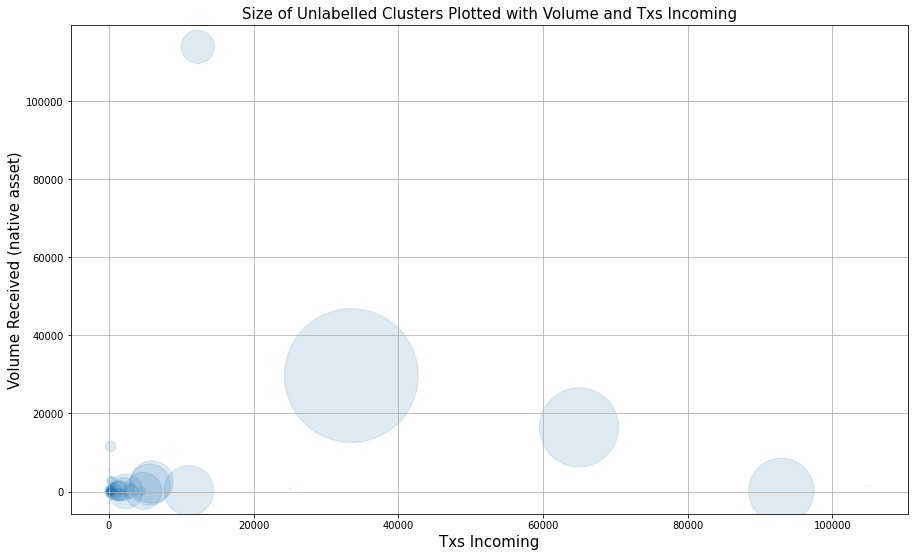

In [57]:
a = scatter_plot()

In [23]:
.

In [25]:
unlabelled.columns

Index(['Address', 'Date', 'URL', 'Scam Type', 'Label', 'Asset', 'balance',
       'btc_in', 'btc_out', 'txs_in', 'txs_out', 'address_count',
       'first_seen_time', 'last_seen_time', 'Elliptic Label', 'Category',
       'Elliptic URL', 'Actor Match'],
      dtype='object')

In [26]:
unlabelled_clusters = unlabelled.drop_duplicates(subset=['balance',
       'btc_in', 'btc_out', 'txs_in', 'txs_out', 'address_count'])

In [27]:
unlabelled_clusters

Address        Date  \
0    1Bpqs8zwvERi7PCXtppUfTuaiLPtEj1uFB  1477004400   
1    3AyrriXecmRMAZiSPjRzgeMawdezm4ZwVh  1484611200   
2    1L4iyxnniiKKAue6yk6kW8AHLypLceP8QX  1484956800   
3    17f7PKkuPBWPZcEmp1Utrzr22iUK9Fergj  1484956800   
5    14CEQAwPfvswFsWKAKVRcyGhJ3iCqtHBBQ  1485388800   
..                                  ...         ...   
487  14Evu6FdnucdxnddM2XJK5TxyzZhDJJX23  1511827200   
488  1NZ3v3gwcuYeToWFCpYTo9zNWknPMvsMgm  1511827200   
491  19gQ1He2KXLiGvGSGBfzuMhYRYWiuRF2Si  1511827200   
496  1FjM2dmtDXQ4W8RzxMPBh4XL6Eh4zrcE62  1511827200   
497  34Mf4eNLJQUvsC3xJEFfZ5ttqRZ9Be2YFh  1511827200   

                                URL  Scam Type  \
0        http://btc-multiplier.com/        NaN   
1                 https://btclab.io        NaN   
2    http://africaohupkmxqrd.onion/        NaN   
3    http://africaohupkmxqrd.onion/        NaN   
5       http://www.the-grain.co.za/        NaN   
..                              ...        ...   
487         https://hourlycoins.biz        NaN   
488            http://recyclix.com/        NaN   
491     https://www.nexusmining.com        NaN   
496    https://www.nexusmining.com/        NaN   
497           https://atlantinv.com        NaN   

                                 Label Asset  balance        btc_in  \
0                BTC MULTIPLIER - SCAM   BTC  0.00000     14.569805   
1                   Bitcoin Laboratory   BTC  0.00000      8.124044   
2    Africa Industry / Africa Products   BTC  0.00000      0.098789   
3    Africa Industry / Africa Products   BTC  0.00000     19.204000   
5                       Buy MMM script   BTC  0.00000     19.942136   
..                                 ...   ...      ...           ...   
487                    hourlycoins.biz   BTC  0.00000      0.379526   
488                           Recyclix   BTC  0.00000      4.561334   
491                        Nexusmining   BTC  0.00000      2.242411   
496                              Nexus   BTC  0.00000      7.257576   
497                 Atlant Investments   BTC  0.35538  16439.520771   

          btc_out   txs_in  txs_out  address_count  first_seen_time  \
0       14.567328      1.0     12.0            1.0     1.473329e+09   
1        8.122879      9.0      5.0            9.0     1.484243e+09   
2        0.098186      1.0      2.0            1.0     1.479994e+09   
3       19.195000     13.0      1.0            1.0     1.479838e+09   
5       19.940780      1.0      2.0            1.0     1.478609e+09   
..            ...      ...      ...            ...              ...   
487      0.377324      4.0      1.0            4.0     1.459503e+09   
488      4.063393    379.0    213.0          414.0     1.455052e+09   
491      2.230085     25.0      9.0            7.0     1.459855e+09   
496      7.257531      1.0      2.0            1.0     1.459979e+09   
497  16404.504540  64977.0    149.0        25044.0     1.460028e+09   

     last_seen_time Elliptic Label Category Elliptic URL  Actor Match  
0      1.511162e+09            NaN      NaN          NaN        False  
1      1.484263e+09            NaN      NaN          NaN        False  
2      1.486629e+09            NaN      NaN          NaN        False  
3      1.485533e+09            NaN      NaN          NaN        False  
5      1.489793e+09            NaN      NaN          NaN        False  
..              ...            ...      ...          ...          ...  
487    1.459505e+09            NaN      NaN          NaN        False  
488    1.483325e+09            NaN      NaN          NaN        False  
491    1.459859e+09            NaN      NaN          NaN        False  
496    1.459982e+09            NaN      NaN          NaN        False  
497    1.460238e+09            NaN      NaN          NaN        False  

[258 rows x 18 columns]

In [21]:
bww

Address        Date  \
0    1Bpqs8zwvERi7PCXtppUfTuaiLPtEj1uFB  1477004400   
1    3AyrriXecmRMAZiSPjRzgeMawdezm4ZwVh  1484611200   
2    1L4iyxnniiKKAue6yk6kW8AHLypLceP8QX  1484956800   
3    17f7PKkuPBWPZcEmp1Utrzr22iUK9Fergj  1484956800   
4    1BASEM9WhpLGguf3hPJvzJGfaWnafuUKB5  1484956800   
..                                  ...         ...   
491  19gQ1He2KXLiGvGSGBfzuMhYRYWiuRF2Si  1511827200   
494  1LAPiYtJo4bMe8xNoYa4uvnZ7mVG1jFnAd  1511827200   
496  1FjM2dmtDXQ4W8RzxMPBh4XL6Eh4zrcE62  1511827200   
497  34Mf4eNLJQUvsC3xJEFfZ5ttqRZ9Be2YFh  1511827200   
499  3JVkrUePR4SXw21p3FpXtaPPdA77tWJ4tk  1511827200   

                                                   URL  Scam Type  \
0                           http://btc-multiplier.com/        NaN   
1                                    https://btclab.io        NaN   
2                       http://africaohupkmxqrd.onion/        NaN   
3                       http://africaohupkmxqrd.onion/        NaN   
4    http://bitcoinminer.pw/frontend/sessionId=e7f2...        NaN   
..                                                 ...        ...   
491                        https://www.nexusmining.com        NaN   
494                            https://hourlycoins.biz        NaN   
496                       https://www.nexusmining.com/        NaN   
497                              https://atlantinv.com        NaN   
499                                                NaN        NaN   

                                 Label Asset     balance         btc_in  \
0                BTC MULTIPLIER - SCAM   BTC    0.000000      14.569805   
1                   Bitcoin Laboratory   BTC    0.000000       8.124044   
2    Africa Industry / Africa Products   BTC    0.000000       0.098789   
3    Africa Industry / Africa Products   BTC    0.000000      19.204000   
4                    bitcoin generator   BTC    1.524186   11253.579879   
..                                 ...   ...         ...            ...   
491                        Nexusmining   BTC    0.000000       2.242411   
494                        HourlyCoins   BTC  162.842217  609849.910055   
496                              Nexus   BTC    0.000000       7.257576   
497                 Atlant Investments   BTC    0.355380   16439.520771   
499                          BitWealth   BTC   30.010798  553954.943525   

           btc_out     txs_in    txs_out  address_count  first_seen_time  \
0        14.567328        1.0       12.0            1.0     1.473329e+09   
1         8.122879        9.0        5.0            9.0     1.484243e+09   
2         0.098186        1.0        2.0            1.0     1.479994e+09   
3        19.195000       13.0        1.0            1.0     1.479838e+09   
4     11250.786034    19332.0     1742.0        11536.0     1.484821e+09   
..             ...        ...        ...            ...              ...   
491       2.230085       25.0        9.0            7.0     1.459855e+09   
494  608047.908750  3431325.0  1050471.0      2853163.0     1.459890e+09   
496       7.257531        1.0        2.0            1.0     1.459979e+09   
497   16404.504540    64977.0      149.0        25044.0     1.460028e+09   
499  553828.798158   352297.0    83687.0       353140.0     1.460349e+09   

     last_seen_time Elliptic Label  Category               Elliptic URL  \
0      1.511162e+09            NaN       NaN                        NaN   
1      1.484263e+09            NaN       NaN                        NaN   
2      1.486629e+09            NaN       NaN                        NaN   
3      1.485533e+09            NaN       NaN                        NaN   
4      1.509851e+09         BTCpop  Exchange         https://btcpop.co/   
..              ...            ...       ...                        ...   
491    1.459859e+09            NaN       NaN                        NaN   
494    1.459975e+09       coins.ph  Exchange                   coins.ph   
496    1.459982e+09            NaN       NaN         

In [ ]:
https://drive.google.com/file/d/1fFaVZb8dZjC0hhOSWCiHZPdctwKAS511/view?usp=sharing

In [10]:
def read_csv_from_drive(
    file_id: str, creds_file: str = DEFAULT_CREDS_FILE, **kwargs
) -> pd.DataFrame:
    drive_service = build_drive_service(creds_file)
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.BytesIO()
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
    fh.seek(0)
    with open("temp.csv", "wb") as f:
        shutil.copyfileobj(fh, f)
    df = pd.read_csv("temp.csv", **kwargs)
    os.remove("temp.csv")
    return df

In [278]:
folder_name1 = 'Bitcoin Whos Who'
file_name = 'bww_data.csv'

In [333]:
drive.files().list(corpora='drive', includeItemsFromAllDrives=True,
                       driveId='0ADBQ6duM6MR-Uk9PVA', supportsAllDrives=True).execute()

{'kind': 'drive#fileList',
 'incompleteSearch': False,
 'files': [{'kind': 'drive#file',
   'id': '1OPlAIzQ9NO3d92nDLmZjrGGib8Ti3UmSCk8WtBsSFxA',
   'name': 'Test File',
   'mimeType': 'application/vnd.google-apps.document',
   'teamDriveId': '0ADBQ6duM6MR-Uk9PVA',
   'driveId': '0ADBQ6duM6MR-Uk9PVA'},
  {'kind': 'drive#file',
   'id': '1uAXESRbyYkmSuJzim5Wdw9TjsATt9LFmLJQMZuTS8Xw',
   'name': 'file3',
   'mimeType': 'application/vnd.google-apps.document',
   'teamDriveId': '0ADBQ6duM6MR-Uk9PVA',
   'driveId': '0ADBQ6duM6MR-Uk9PVA'},
  {'kind': 'drive#file',
   'id': '1pn_fZ1RYEmjGCagE78cpva1k6p4N5sH-',
   'name': 'Test File',
   'mimeType': 'application/vnd.google-apps.folder',
   'teamDriveId': '0ADBQ6duM6MR-Uk9PVA',
   'driveId': '0ADBQ6duM6MR-Uk9PVA'},
  {'kind': 'drive#file',
   'id': '19GPHSq3kM0O32JMy6HQCj1u-Sn0ISHxq',
   'name': 'bww_data.csv',
   'mimeType': 'text/csv',
   'teamDriveId': '0ADBQ6duM6MR-Uk9PVA',
   'driveId': '0ADBQ6duM6MR-Uk9PVA'},
  {'kind': 'drive#file',
   '

In [30]:
def get_folder_id(folder_name):
    
    all_files = drive.files().list(corpora='drive', includeItemsFromAllDrives=True,
                       driveId='0ADBQ6duM6MR-Uk9PVA', supportsAllDrives=True,
                      q="mimeType = 'application/vnd.google-apps.folder'").execute()
        
    for entry in all_files['files']:
        if str(entry['name']) == str(folder_name):
            return entry['id']

In [88]:
def get_drive_item(file_name: str, item_type=None):
    
    if (item_type is not None) and (item_type not in ['document', 'file', 'folder', 'photo', 'spreadsheet']):
        
        raise Exception('Parameter item_type must be None or one of "document", "file", "folder",\
                        "photo" or "spreadsheet".')
    
    if item_type is None:
        q = None
    else:
        q ="mimeType = 'application/vnd.google-apps.{}'".format(item_type)
    
    all_files = drive.files().list(corpora='drive', includeItemsFromAllDrives=True,
                       driveId='0ADBQ6duM6MR-Uk9PVA', supportsAllDrives=True,
                        q=q).execute()
    
    for file in all_files['files']:
        if str(file['name']) == str(file_name):
            return file

In [346]:
all_files = drive.files().list(corpora='drive', includeItemsFromAllDrives=True,
                       driveId='0ADBQ6duM6MR-Uk9PVA', supportsAllDrives=True,
                        q=None).execute()

In [81]:
all_files

{'kind': 'drive#fileList',
 'incompleteSearch': False,
 'files': [{'kind': 'drive#file',
   'id': '1uAXESRbyYkmSuJzim5Wdw9TjsATt9LFmLJQMZuTS8Xw',
   'name': 'file3',
   'mimeType': 'application/vnd.google-apps.document',
   'teamDriveId': '0ADBQ6duM6MR-Uk9PVA',
   'driveId': '0ADBQ6duM6MR-Uk9PVA'},
  {'kind': 'drive#file',
   'id': '1OPlAIzQ9NO3d92nDLmZjrGGib8Ti3UmSCk8WtBsSFxA',
   'name': 'Test File',
   'mimeType': 'application/vnd.google-apps.document',
   'teamDriveId': '0ADBQ6duM6MR-Uk9PVA',
   'driveId': '0ADBQ6duM6MR-Uk9PVA'},
  {'kind': 'drive#file',
   'id': '1pn_fZ1RYEmjGCagE78cpva1k6p4N5sH-',
   'name': 'Test File',
   'mimeType': 'application/vnd.google-apps.folder',
   'teamDriveId': '0ADBQ6duM6MR-Uk9PVA',
   'driveId': '0ADBQ6duM6MR-Uk9PVA'},
  {'kind': 'drive#file',
   'id': '19GPHSq3kM0O32JMy6HQCj1u-Sn0ISHxq',
   'name': 'bww_data.csv',
   'mimeType': 'text/csv',
   'teamDriveId': '0ADBQ6duM6MR-Uk9PVA',
   'driveId': '0ADBQ6duM6MR-Uk9PVA'},
  {'kind': 'drive#file',
   '

In [426]:
get_folder_id('packs')

In [427]:
get_drive_item('All Graphsense Data')

{'kind': 'drive#file',
 'id': '1nPdzlue1Dhfu1umYIXdR4oonJPs42FNs',
 'name': 'All Graphsense Data',
 'mimeType': 'application/vnd.google-apps.folder',
 'teamDriveId': '0ADBQ6duM6MR-Uk9PVA',
 'driveId': '0ADBQ6duM6MR-Uk9PVA'}

In [4]:
with open("/Users/eddie.lyons/Downloads/walletexplorer.yaml", "r") as f:
    data=f.read()
    x = yaml.safe_load(data)
    return pd.DataFrame.from_dict(x, orient='columns')

In [6]:
pd.DataFrame.from_dict(x, orient='columns')

title          creator  \
0    Wallet Explorer Tags  GraphSense Team   
1    Wallet Explorer Tags  GraphSense Team   
2    Wallet Explorer Tags  GraphSense Team   
3    Wallet Explorer Tags  GraphSense Team   
4    Wallet Explorer Tags  GraphSense Team   
..                    ...              ...   
377  Wallet Explorer Tags  GraphSense Team   
378  Wallet Explorer Tags  GraphSense Team   
379  Wallet Explorer Tags  GraphSense Team   
380  Wallet Explorer Tags  GraphSense Team   
381  Wallet Explorer Tags  GraphSense Team   

                              description currency     lastmod  \
0    Scraped tags from walletexplorer.com      BTC  2019-06-18   
1    Scraped tags from walletexplorer.com      BTC  2019-06-18   
2    Scraped tags from walletexplorer.com      BTC  2019-06-18   
3    Scraped tags from walletexplorer.com      BTC  2019-06-18   
4    Scraped tags from walletexplorer.com      BTC  2019-06-18   
..                                    ...      ...         ...   
377  Scraped tags from walletexplorer.com      BTC  2019-06-18   
378  Scraped tags from walletexplorer.com      BTC  2019-06-18   
379  Scraped tags from walletexplorer.com      BTC  2019-06-18   
380  Scraped tags from walletexplorer.com      BTC  2019-06-18   
381  Scraped tags from walletexplorer.com      BTC  2019-06-18   

                                                  tags  
0    {'address': '38f8RHFQ8v6avZqCmaYTga5bTYiuhoM6f...  
1    {'address': '14S2cUvnYig1rvejbPWqJDsFAhh1F13Kr...  
2    {'address': '1FtMAGbhsxRNc3GBUunKRk57e5hxdqYwV...  
3    {'address': '17ac9tXHxu1nxdLgLu9WYk7vR8ggFN5Gk...  
4    {'address': '171LFo1rr4oSE6CDkV7NxyCfwX2sMXJZt...  
..                                                 ...  
377  {'address': '13iMZjXxQuq8WpsrVrEARouGiwa7Ec41m...  
378  {'address': '1HpeCDwDxdB1Ad5Fx1QdSyPoWv2AUuuGo...  
379  {'address': '18kKnQjFz9rfYSwJhsBF8y4fksXCnAkfg...  
380  {'address': '3JkSwgHew9QBsFNufrw4qmMW5mAnQJZXe...  
381  {'address': '16PMJGm6TE2Se16wRf9xuGFYiJBnT1FVA...  

[382 rows x 6 columns]

In [7]:
a = None

In [8]:
a['tags']

TypeError: 'NoneType' object is not subscriptable